In [45]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [46]:
env = BlackjackEnv()

In [47]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        if np.random.random_sample() < epsilon:
            # Randomly select an action
            action = np.random.choice(nA)
            # deterministically pick that action
            action_probs = np.eye(nA)[action]
            return action_probs
        
        # pick the action with the highest Q value
        action_values = Q[observation]
        best_action = np.argmax(action_values)
        action_probs = np.eye(nA)[best_action]
        return action_probs

    return policy_fn

In [48]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        observation = env.reset()
        # list of (state, action, reward)
        episode = []
        # Begin Episode
        while True:
            action_probs = policy(observation)
            action = np.random.choice(len(action_probs), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((observation, action, reward))
            if done:
                # The only reward is this last one
                break
            observation = next_state
        # End Episode

        states_visited = {} # (state, action) -> idx of first visit
        for i, step in enumerate(episode):
            state, action, _ = step
            if (state, action) not in states_visited:
                states_visited[(state, action)] = i
        
        for sa, first_visit in states_visited.items():
            state, action_taken = sa
            assert(episode[first_visit][0] == state)
            # find return
            G = 0
            gamma_exp = 1
            for i in range(first_visit, len(episode)):
                G += gamma_exp * episode[i][2]
                gamma_exp *= discount_factor
            returns_sum[sa] += G
            returns_count[sa] += 1.0
            Q[state][action_taken] = returns_sum[sa] / returns_count[sa]
        
        # policy is updated because of its dependence on Q
    
    return Q, policy

In [49]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)
# Q, policy = mc_control_epsilon_greedy(env, num_episodes=5000, epsilon=0.1)

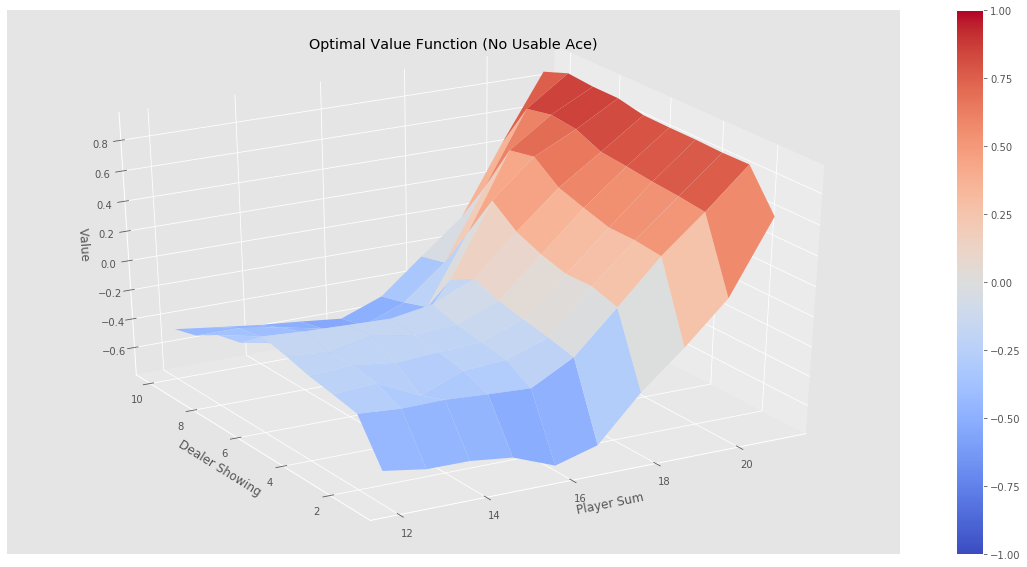

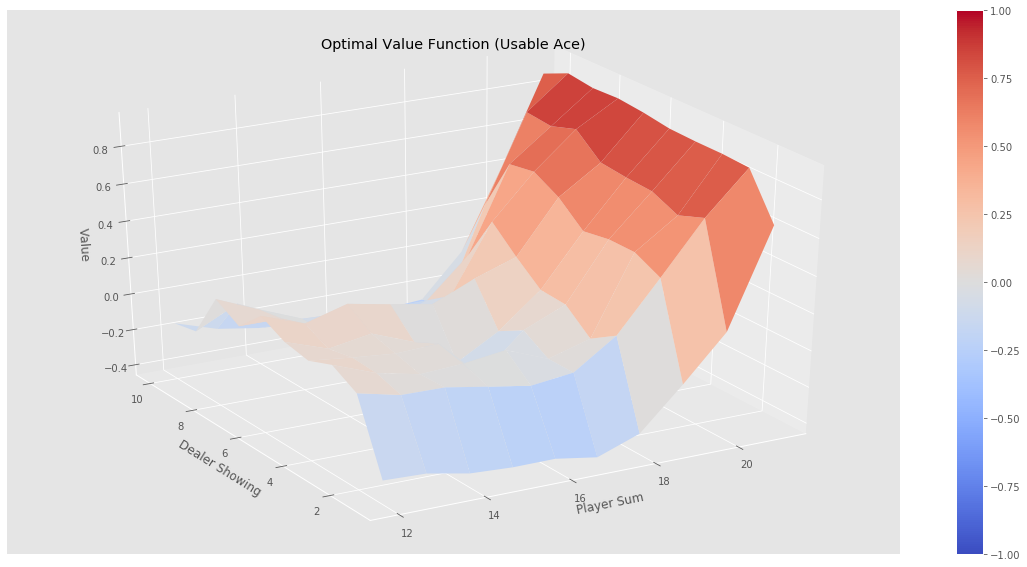

In [50]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")